 # "Creating Customer Segments" 
 
 ## Project Review 
   
 > Created on:	8 September 2017

### Data Exploration

> Three separate samples of the data are chosen and their establishment representations are proposed based on the statistical description of the dataset.
 
You could also visualize each sample in terms of the underlying features:

In [ ]:
centers = true_centers.copy()
centers[true_centers.shape[0]] = data.median()

plt.style.use('ggplot')
centers.plot(kind='bar')
labels = true_centers.index.values.tolist()
labels.append("Data Median")
plt.xticks(range(true_centers.shape[0]),labels)

A critical concept that is lying just beneath the surface with this project are the ideas of standardization and normalization.

https://en.wikipedia.org/wiki/Normalization_(statistics)

You can start thinking about this idea while looking at the samples, by applying a simple numpy transformation to the data:

In [ ]:
samples_sc = (samples - data.mean())/data.std()

Note that this is ignoring the concept of degrees of freedom.

Having performed the transformation, the values of the scaled samples represent the number of standard deviations from the mean of the dataset for each value. This allows you to compare "apples" to "oranges", that is, data collected on difference scales in a meaningful way.

> A prediction score for the removed feature is accurately reported. Justification is made for whether the removed feature is relevant.

Make sure you are clear that this test reveals that a feature may be unnecessary. The removal of a feature may fail to capture non-linear interactions!

I used the code below to study all of the features over 100 randomly generated trials. Such an analysis can tell you a lot about the correlation between all of the features. Are there others with higher R^2 scores?

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

def calculate_r_2_for_feature(data,feature):
    new_data = data.drop(feature, axis=1)

    X_train, \
    X_test,  \
    y_train, \
    y_test = train_test_split(
        new_data,data[feature],test_size=0.25
    )

    regressor = DecisionTreeRegressor()
    regressor.fit(X_train,y_train)

    score = regressor.score(X_test,y_test)
    return score

def r_2_mean(data,feature,runs=200):
    return np.array([calculate_r_2_for_feature(data,feature)
                     for _ in range(200) ]).mean().round(4)

print "{0:17} {1}".format("Fresh: ", r_2_mean(data,'Fresh'))
print "{0:17} {1}".format("Milk: ", r_2_mean(data,'Milk'))
print "{0:17} {1}".format("Grocery: ", r_2_mean(data,'Grocery'))
print "{0:17} {1}".format("Frozen: ", r_2_mean(data,'Frozen'))
print "{0:17} {1}".format("Detergents_Paper: ", r_2_mean(data,'Detergents_Paper'))
print "{0:17} {1}".format("Delicatessen: ", r_2_mean(data,'Delicatessen'))

> Student identifies features that are correlated and compares these features to the predicted feature. Student further discusses the data distribution for those features.

Strong correlations can be connected back to the R^2 from the previous analysis.

A negative R^2 implies that the corresponding feature cannot be estimated by a linear combination of all other features, that is that it is uncorrelated with any other features, thus making it important for predicting customer behavior. A positive R^2 implies that the corresponding feature is correlated that is that it is linearly dependent with the other features and possibly not important.

I used this to visualize correlations:

In [ ]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True,
                     cmap='RdBu', fmt='+.3f')
    plt.xticks(rotation=45, ha='center')

Understanding the distribution of data is critical. A normal distribution is critical for a well behaving principal component analysis.

## Data Preprocessing

>Feature scaling for both the data and the sample data has been properly implemented in code.

This helped me to see the distribution of data before and after scaling:

In [ ]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
fig.set_size_inches(18, 6)
fig.suptitle('Distribution of Features')

for i, col in enumerate(data.columns):
    feature = data[col]
    sns.distplot(feature, label=col, ax=axes[i]).set(xlim=(-1000, 20000),)
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')

In this plot, we can actually see the distribution. We can see that most of the features are log-normal, that is, they have a distribution such that their logarithm has a normal distribution. This implies that we can achieve a normal distribution for our data simply by taking the logarithm of the data.

After preparing the log data, we can look at the distribution again:

In [ ]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
fig.set_size_inches(18, 6)
fig.suptitle('Distribution of Features for Log Data')

for i, col in enumerate(log_data.columns):
    feature = log_data[col]
    sns.distplot(feature, label=col, ax=axes[i])
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')

From these you can think about skewness in data:

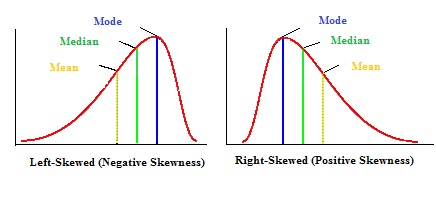

To compare the log-transformed feature distributions, you can also plot them on top of each other with a seaborn KDE plot...

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# set plot style & color scheme
sns.set_style('ticks')
with sns.color_palette("Reds_r"):
    # plot densities of log data
    plt.figure(figsize=(8,4))
    for col in data.columns:
        sns.kdeplot(log_data[col], shade=True)
    plt.legend(loc='best')

Perhaps most importantly, by taking the log of the data, we have actually placed the data on similar scales. This will be critical when we perform our principal component analysis.



> NEXT LEVEL SUGGESTION

Strictly speaking, a principal component analysis assumes that data has a mean of zero and a variance of 1. If you think about it, the PCA is completely based upon the variance and co-variance in the data. This requires that the data can be completely described using the variance and co-variance i.e. that the mean is zero. We need to have the variance of each feature set to 1 so that no feature comes to dominate the PCA. To achieve this you can scale the log_data.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(log_data)

log_data = scaler.transform(log_data)
log_samples = scaler.transform(log_samples)

If you do this, you will need to apply the following to transform your data back in Implementation: Data Recovery.

In [ ]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = scaler.inverse_transform(log_centers)
true_centers = np.exp(true_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

> Student identifies extreme outliers and discusses whether the outliers should be removed. Justification is made for any data points removed.

Some helpful links on outliers:

http://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/
http://graphpad.com/guides/prism/6/statistics/index.htm?stat_checklist_identifying_outliers.htm

You can also find the double counted outliers programatically using a Counter:

In [ ]:
from collections import Counter

## Feature Transformation

> The total variance explained for two and four dimensions of the data from PCA is accurately reported. The first four dimensions are interpreted as a representation of customer spending with justification.

A principal component is an engineered feature made from the original features. The first dimension has 4 features correlated together and to features correlated in the other direction. The sign of the features can not be interpreted. The signs are actually reversible, and if you run it multiple times on your computer you may have noticed this. Have a look at
http://stats.stackexchange.com/questions/30348/is-it-acceptable-to-reverse-a-sign-of-a-principal-component-scorecorrelated
What we are looking for here is the largest absolute value magnitude features. These are the features that are most heavily represented.

Further reading:
You can read more about how to interpret the dimensions here:

https://onlinecourses.science.psu.edu/stat505/node/54
http://setosa.io/ev/principal-component-analysis/
https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
https://www.quora.com/What-is-an-intuitive-explanation-for-PCA
I used this to show the cumulative variance:

In [ ]:
# create an x-axis variable for each pca component
x = np.arange(1,7)

# plot the cumulative variance
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-o', color='black')

# plot the components' variance
plt.bar(x, pca.explained_variance_ratio_, align='center', alpha=0.5)

# plot styling
plt.ylim(0, 1.05)
plt.annotate('Cumulative\nexplained\nvariance',
             xy=(3.7, .88), arrowprops=dict(arrowstyle='->'), xytext=(4.5, .6))
for i,j in zip(x, np.cumsum(pca.explained_variance_ratio_)):
    plt.annotate(str(j.round(4)),xy=(i+.2,j-.02))
plt.xticks(range(1,7))
plt.xlabel('PCA components')
plt.ylabel('Explained Variance')
plt.show()

If you really want to understand PCA, I recommend MIT's 1806 course, especially eigenvalues and vectors:

https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/index.htm

> PCA has been properly implemented and applied to both the scaled data and scaled sample data for the two-dimensional case in code.

## Clustering

> The Gaussian Mixture Model and K-Means algorithms have been compared in detail. Student’s choice of algorithm is justified based on the characteristics of the algorithm and data.

Some helpful links:

http://home.deib.polimi.it/matteucc/Clustering/tutorial_html/mixture.html
http://www.nickgillian.com/wiki/pmwiki.php/GRT/GMMClassifier
http://playwidtech.blogspot.hk/2013/02/k-means-clustering-advantages-and.html
http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/K-Means_Clustering_Overview.htm
http://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means
http://www.r-bloggers.com/k-means-clustering-is-not-a-free-lunch/
http://www.r-bloggers.com/pca-and-k-means-clustering-of-delta-aircraft/
https://shapeofdata.wordpress.com/2013/07/30/k-means/
http://mlg.eng.cam.ac.uk/tutorials/06/cb.pdf
https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian

> Several silhouette scores are accurately reported, and the optimal number of clusters is chosen based on the best reported score. The cluster visualization provided produces the optimal number of clusters based on the clustering algorithm chosen.

Suggestion:
The choice of outliers is very important for the silhouette scores of your outliers. What if you ran your analysis again, this time without removing any outliers? How would the number of clusters and silhouette scores vary?

> The establishments represented by each customer segment are proposed based on the statistical description of the dataset. The inverse transformation and inverse scaling has been properly implemented and applied to the cluster centers in code.

You could also visualize each segment in terms of the underlying features:

In [ ]:
centers = true_centers.copy()
centers.loc[centers.shape[0]] = data.median()
centers.loc[centers.shape[0]] = data.mean()

plt.style.use('ggplot')
centers.plot(kind='bar')
labels = true_centers.index.values.tolist()
labels.append("Data Median")
labels.append("Data Mean")
plt.xticks(range(centers.shape[0]+1),labels)

> Sample points are correctly identified by customer segment, and the predicted cluster for each sample point is discussed.

## Conclusion

> Student correctly identifies how an A/B test can be performed on customers after a change in the wholesale distributor’s service.

You might think about the power of the change:

Power. I've seen a lot of people say things like "oh, that A/B test was neutral, but we should launch it anyways because we think it will be good for the user." I think that's fine if the A/B test is well-run, but I've seen many cases where the reason the A/B test is neutral is because it doesn't have sufficient power (e.g., even a 50% drop in metrics wouldn't have been statistically significant). In the long-term, the supposedly "neutral" experiment might actually lead to a 30% drop in revenue

https://www.quora.com/When-should-A-B-testing-not-be-trusted-to-make-decisions/answer/Edwin-Chen-1

> Student discusses with justification how the clustering data can be used in a supervised learner for new predictions.

Here is an online discussion about using unsupervised learning to generate a target: https://datascience.stackexchange.com/questions/985/can-i-use-unsupervised-learning-followed-by-supervised-learning

> Comparison is made between customer segments and customer ‘Channel’ data. Discussion of customer segments being identified by ‘Channel’ data is provided, including whether this representation is consistent with previous results.